# Data Collection

In [2]:
pip install kagglehub


   ---------------------------------------- 0.0/43.0 kB ? eta -:--:--
   ---------------------------- ----------- 30.7/43.0 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- - 41.0/43.0 kB 653.6 kB/s eta 0:00:01
   -------------------------------------- - 41.0/43.0 kB 653.6 kB/s eta 0:00:01
   -------------------------------------- - 41.0/43.0 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 43.0/43.0 kB 149.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install kaggle



     ---------------------------------------- 0.0/82.7 kB ? eta -:--:--
     ---------------------------------------- 0.0/82.7 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/82.7 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/82.7 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/82.7 kB ? eta -:--:--
     ---- ----------------------------------- 10.2/82.7 kB ? eta -:--:--
     -------------- ----------------------- 30.7/82.7 kB 119.1 kB/s eta 0:00:01
     -------------- ----------------------- 30.7/82.7 kB 119.1 kB/s eta 0:00:01
     ------------------ ------------------- 41.0/82.7 kB 115.5 kB/s eta 0:00:01
     ---------------------------- --------- 61.4/82.7 kB 163.6 kB/s eta 0:00:01
     -------------------------------------  81.9/82.7 kB 199.7 kB/s eta 0:00:01
     -------------------------------------  81.9/82.7 kB 199.7 kB/s eta 0:00:01
     -------------------------------------- 82.7/82.7 kB 154.5 kB/s eta 0:00:00
  P

In [6]:
import os

os.environ['KAGGLE_USERNAME'] = 'ebenezerds'
os.environ['KAGGLE_KEY'] = 'kaggle.json'


In [9]:
import os
import requests
from tqdm import tqdm

def download_kaggle_dataset(dataset_name, save_path):
    os.makedirs(save_path, exist_ok=True)

    # Build Kaggle API download URL
    url = f"https://www.kaggle.com/api/v1/datasets/download/{dataset_name}"

    # Prepare headers for the request
    kaggle_api_token_path = os.path.expanduser("~/.kaggle/kaggle.json")
    with open(kaggle_api_token_path, "r") as f:
        import json
        kaggle_credentials = json.load(f)
    auth = (kaggle_credentials["username"], kaggle_credentials["key"])

    # Perform download with progress bar
    response = requests.get(url, stream=True, auth=auth)
    total_size = int(response.headers.get("content-length", 0))

    zip_path = os.path.join(save_path, f"{dataset_name.split('/')[-1]}.zip")

    with open(zip_path, "wb") as file, tqdm(
        desc=f"Downloading {dataset_name}",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)
            bar.update(len(data))

    print(f"Dataset downloaded to {zip_path}")

# Example usage
dataset_name = "andradaolteanu/gtzan-dataset-music-genre-classification"
save_path = "./data"
download_kaggle_dataset(dataset_name, save_path)


Dataset downloaded to ./data\gtzan-dataset-music-genre-classification.zip


# Data Preprocessing 

In [11]:
pip install librosa

   ---------------------------------------- 0.0/260.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/260.1 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/260.1 kB 660.6 kB/s eta 0:00:01
   ---- ---------------------------------- 30.7/260.1 kB 660.6 kB/s eta 0:00:01
   ------ -------------------------------- 41.0/260.1 kB 245.8 kB/s eta 0:00:01
   ------------ -------------------------- 81.9/260.1 kB 383.3 kB/s eta 0:00:01
   ---------------- --------------------- 112.6/260.1 kB 504.4 kB/s eta 0:00:01
   ----------------- -------------------- 122.9/260.1 kB 450.6 kB/s eta 0:00:01
   ----------------------------- -------- 204.8/260.1 kB 593.2 kB/s eta 0:00:01
   -------------------------------- ----- 225.3/260.1 kB 573.4 kB/s eta 0:00:01
   -------------------------------------  256.0/260.1 kB 605.3 kB/s eta 0:00:01
   -------------------------------------  256.0/260.1 kB 605.3 kB/s eta 0:00:01
   -------------------------------------- 260.1/260.1 kB 

In [15]:
import zipfile

def unzip_dataset(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")

zip_path = f"{save_path}/gtzan-dataset-music-genre-classification.zip"
unzip_dataset(zip_path, save_path)


Dataset extracted to ./data


In [1]:
import librosa
import numpy as np
import os
import pandas as pd

def preprocess_audio(audio_path, sr=22050, duration=120):
    """
    Preprocess an audio file:
    1. Load and resample to fixed sampling rate
    2. Trim or pad to fixed duration
    3. Normalize
    """
    try:
        audio, _ = librosa.load(audio_path, sr=sr, mono=True, duration=duration)
        # Pad if shorter than required length
        required_length = sr * duration
        if len(audio) < required_length:
            audio = np.pad(audio, (0, required_length - len(audio)))
        elif len(audio) > required_length:
            audio = audio[:required_length]

        # Normalize the audio
        audio = librosa.util.normalize(audio)
        return audio
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None


# Feature Engineering

In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load image data and preprocess
def load_image_data(image_folder, img_size=(224, 224)):
    features = []
    labels = []
    genres = os.listdir(image_folder)
    
    for genre in genres:
        genre_folder = os.path.join(image_folder, genre)
        for file in os.listdir(genre_folder):
            img_path = os.path.join(genre_folder, file)
            image = cv2.imread(img_path)
            image = cv2.resize(image, img_size)  # Resize images to 224x224
            features.append(image)
            labels.append(genre)
    
    return np.array(features), np.array(labels)

# Load and preprocess image dataset
image_X, image_y = load_image_data('./data/Data/images_original')

# Normalize pixel values
image_X = image_X / 255.0

# Encode labels
le_image = LabelEncoder()
image_y_encoded = le_image.fit_transform(image_y)
image_y_encoded = to_categorical(image_y_encoded, num_classes=len(le_image.classes_))

# Train-test split
image_X_train, image_X_test, image_y_train, image_y_test = train_test_split(
    image_X, image_y_encoded, test_size=0.2, random_state=42
)


In [1]:
import os
import librosa
import numpy as np
from librosa.display import specshow
import random
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

def extract_mfcc_features(audio, sr=22050, n_mfcc=13):
    """
    Extract MFCC features from audio signal.
    """
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

def preprocess_audio(audio_path, sr=22050, duration=30):
    """
    Load and preprocess audio by trimming to the desired duration.
    """
    try:
        audio, _ = librosa.load(audio_path, sr=sr, mono=True, duration=duration)
        return audio
    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return None

def augment_audio(audio, sr=22050):
    """
    Apply data augmentation to audio.
    """
    # Random time shift
    shift = np.random.randint(int(sr * 0.1))
    audio_shifted = np.roll(audio, shift)

    # Random frequency masking
    freq_mask_param = np.random.randint(0, 10)
    freq_masked = librosa.effects.time_stretch(audio_shifted, rate=random.uniform(0.9, 1.1))

    return freq_masked

def process_dataset(data_path, sr=22050, duration=30, n_mfcc=13):
    """
    Process all audio files in the dataset and extract MFCC features with data augmentation.
    """
    features = []
    labels = []

    genres = os.listdir(data_path)
    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file_name)
                if file_path.endswith('.wav'):
                    audio = preprocess_audio(file_path, sr=sr, duration=duration)
                    if audio is not None:
                        # Original features
                        mfccs = extract_mfcc_features(audio, sr=sr, n_mfcc=n_mfcc)
                        features.append(mfccs)
                        labels.append(genre)

                        # Augmented features
                        augmented_audio = augment_audio(audio, sr)
                        mfccs_aug = extract_mfcc_features(augmented_audio, sr=sr, n_mfcc=n_mfcc)
                        features.append(mfccs_aug)
                        labels.append(genre)

    return np.array(features), np.array(labels)

# Process Dataset
data_path = './data/Data/genres_original'
audio_features, audio_labels = process_dataset(data_path)


C:\Users\ebene\AppData\Local\Temp\ipykernel_6784\1041335988.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(audio_path, sr=sr, mono=True, duration=duration)
c:\Users\ebene\anaconda3\envs\Project\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file ./data/Data/genres_original\jazz\jazz.00054.wav: 


In [2]:
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def process_image_dataset(data_path, img_size=(128, 128)):
    """
    Process all image files in the dataset and extract features.
    """
    features = []
    labels = []
    
    genres = os.listdir(data_path)  # List of genre folders
    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        if os.path.isdir(genre_path):
            for file_name in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file_name)
                if file_path.endswith(('.png', '.jpg', '.jpeg')):  # Image files
                    img = cv2.imread(file_path)
                    img_resized = cv2.resize(img, img_size)
                    features.append(img_resized)
                    labels.append(genre)
    
    return np.array(features), np.array(labels)

# Correct path for image dataset
image_data_path = './data/Data/images_original'
image_features, image_labels = process_image_dataset(image_data_path)

# Encode labels
le_image = LabelEncoder()
image_labels_encoded = le_image.fit_transform(image_labels)
image_labels_onehot = to_categorical(image_labels_encoded)

# Train/test split
image_X_train, image_X_test, image_y_train, image_y_test = train_test_split(
    image_features, image_labels_onehot, test_size=0.2, random_state=42
)


# Model Building

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, Flatten, Add
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def residual_block(x, filters, kernel_size=3):
    res = x
    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, res])
    x = Dropout(0.3)(x)
    return x

def build_advanced_audio_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Residual Blocks
    for _ in range(2):
        x = residual_block(x, 64)
    
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (audio_features.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(audio_features[..., np.newaxis], to_categorical(LabelEncoder().fit_transform(audio_labels)), test_size=0.2, random_state=42)
model = build_advanced_audio_model(input_shape, y_train.shape[1])

callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_audio_model.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

## Compute class weights
unique_classes = np.unique(audio_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=audio_labels)

# Convert to dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(unique_classes))}

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,  # Use the dictionary
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.1698 - loss: 2.2618 - val_accuracy: 0.3225 - val_loss: 1.7649 - learning_rate: 3.0000e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3321 - loss: 1.8841 - val_accuracy: 0.4150 - val_loss: 1.6057 - learning_rate: 3.0000e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3733 - loss: 1.7560 - val_accuracy: 0.4475 - val_loss: 1.5478 - learning_rate: 3.0000e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3893 - loss: 1.6591 - val_accuracy: 0.4825 - val_loss: 1.4209 - learning_rate: 3.0000e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4404 - loss: 1.5477 - val_accuracy: 0.4700 - val_loss: 1.4486 - learning_rate: 3.0000e-04
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4475 - loss: 1.5306 - val_accuracy: 0.4875 - val_loss: 1.3767 - learning_rate: 3.0000e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy:

In [6]:
model.save('best_audio_model.h5')

In [13]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Define ResNet50-based model
def build_advanced_image_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

image_model = build_advanced_image_model((224, 224, 3), len(le_image.classes_))

# Training
image_model.fit(image_X_train, image_y_train, validation_data=(image_X_test, image_y_test), epochs=50, batch_size=32)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 775s 25s/step - accuracy: 0.1864 - loss: 2.5585 - val_accuracy: 0.0600 - val_loss: 19.9898
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 461s 18s/step - accuracy: 0.2794 - loss: 2.0758 - val_accuracy: 0.0900 - val_loss: 57.5522
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 449s 18s/step - accuracy: 0.3110 - loss: 1.9092 - val_accuracy: 0.0900 - val_loss: 34.0169
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 431s 17s/step - accuracy: 0.3298 - loss: 1.8581 - val_accuracy: 0.0600 - val_loss: 34.3104
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 434s 17s/step - accuracy: 0.4153 - loss: 1.6859 - val_accuracy: 0.0600 - val_loss: 17.5169
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 480s 19s/step - accuracy: 0.3907 - loss: 1.7276 - val_accuracy: 0.0600 - val_loss: 15.5668
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 489s 20s/step - accuracy: 0.4589 - loss: 1.5036 - val_accuracy: 0.0600 - val_loss: 8.4355
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 457s 18s/step - accuracy: 0.4702 - loss: 1.4894 - val_accura

In [7]:
pip install soundfile


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: soundfile in c:\users\ebene\anaconda3\envs\project\lib\site-packages (0.12.1)



In [18]:
import pandas as pd

df = pd.read_csv('data/Data/features_30_sec.csv')

df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [20]:
db = pd.read_csv('data/Data/features_3_sec.csv')

db.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# Model Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step
Classification Report for Image Model:

              precision    recall  f1-score   support

       blues       0.40      0.19      0.26        21
   classical       0.83      0.83      0.83        12
     country       0.67      0.08      0.15        24
       disco       1.00      0.09      0.17        22
      hiphop       0.48      0.67      0.56        15
        jazz       1.00      0.37      0.54        27
       metal       0.18      1.00      0.31        18
         pop       0.39      0.47      0.43        19
      reggae       0.60      0.14      0.22        22
        rock       0.06      0.05      0.06        20

    accuracy                           0.34       200
   macro avg       0.56      0.39      0.35       200
weighted avg       0.58      0.34      0.33       200



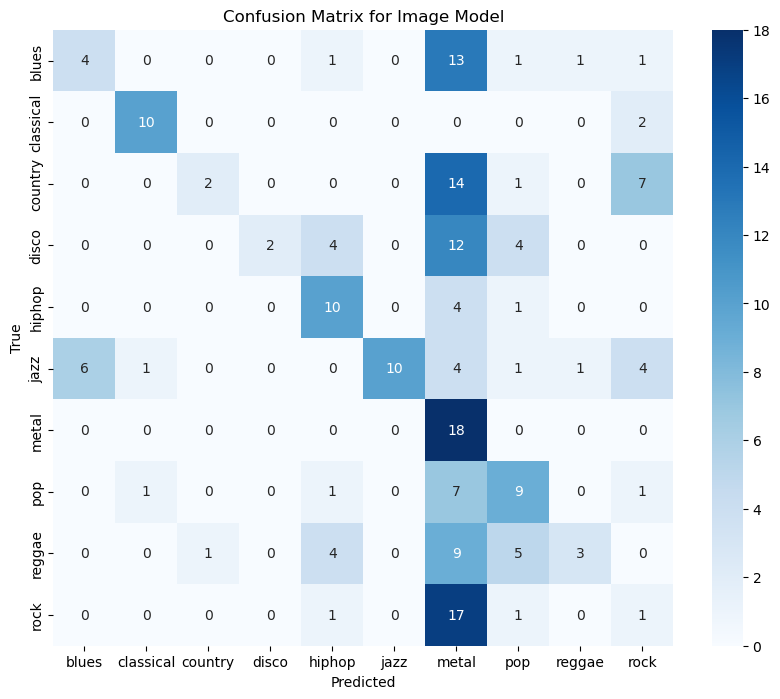

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Save the final model
image_model.save('final_image_model.keras')

# Predictions
y_pred = image_model.predict(image_X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(image_y_test, axis=1)

# Classification report
class_labels = list(le_image.classes_)  # Ensure 'le_image.classes_' gives class names
print("Classification Report for Image Model:\n")
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix for Image Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
from tensorflow.keras.models import load_model

# Load the saved model
image_model = load_model('final_image_model.h5')



13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step


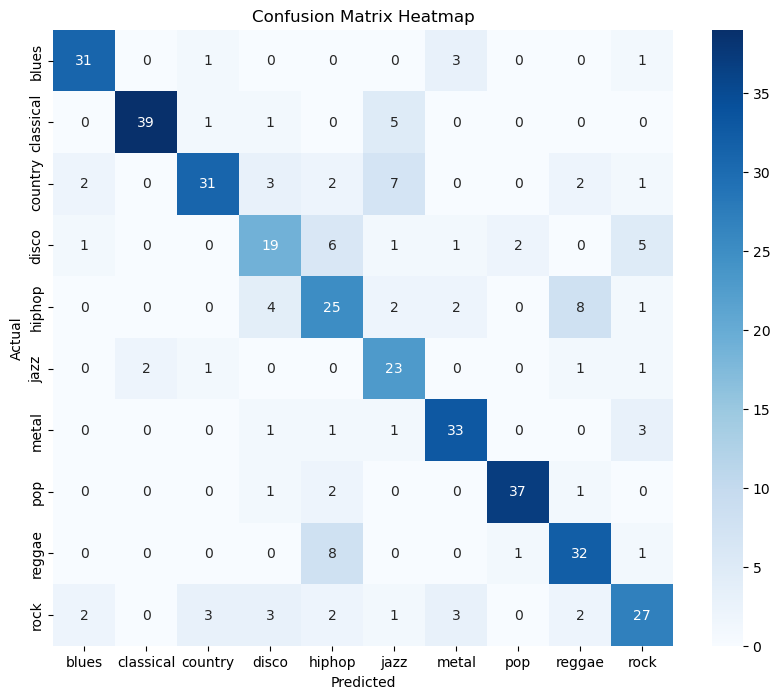

              precision    recall  f1-score   support

       blues       0.86      0.86      0.86        36
   classical       0.95      0.85      0.90        46
     country       0.84      0.65      0.73        48
       disco       0.59      0.54      0.57        35
      hiphop       0.54      0.60      0.57        42
        jazz       0.57      0.82      0.68        28
       metal       0.79      0.85      0.81        39
         pop       0.93      0.90      0.91        41
      reggae       0.70      0.76      0.73        42
        rock       0.68      0.63      0.65        43

    accuracy                           0.74       400
   macro avg       0.74      0.75      0.74       400
weighted avg       0.75      0.74      0.74       400



In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(audio_labels), yticklabels=np.unique(audio_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=np.unique(audio_labels)))
